In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
DATASET_PATH ="/content/drive/MyDrive/speech-emotion-recognition-ravdess-data"
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [ ]:
def extract_features(file_name):

  y, sr = librosa.load(file_name, sr=None)
  features = np.array([])

  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
  features = np.hstack((features, mfccs))

  stft =np.abs(librosa.stft(y))
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
  features = np.hstack((features, chroma))

  mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
  features = np.hstack((features, mel))

  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
  features = np.hstack((features, contrast))

  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
  features = np.hstack((features, tonnetz))

  return features

In [ ]:
def load_data(dataset_path):
    features = []
    labels = []

    print("Dataset path:", dataset_path)
    print("Folders in dataset:", os.listdir(dataset_path))

    for folder in os.listdir(dataset_path):
        actor_folder = os.path.join(dataset_path, folder)

        if os.path.isdir(actor_folder):
            print("Processing folder:", folder)

            for file in os.listdir(actor_folder):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_folder, file)
                    print("Processing file:", file)

                    emotion_code = file.split("-")[2]
                    emotion = emotion_map.get(emotion_code)

                    if emotion is None:
                        print(f"Unknown emotion code {emotion_code} in file {file}")
                        continue

                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(emotion)

    print(f"Total files processed: {len(features)}")
    return np.array(features), np.array(labels)


In [ ]:
X , y = load_data(DATASET_PATH)

Dataset path: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data
Folders in dataset: ['Actor_05', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_01']
Processing folder: Actor_05
Processing file: 03-01-01-01-02-01-05.wav
Processing file: 03-01-02-01-01-01-05.wav
Processing file: 03-01-01-01-02-02-05.wav
Processing file: 03-01-01-01-01-01-05.wav
Processing file: 03-01-01-01-01-02-05.wav
Processing file: 03-01-03-02-01-01-05.wav
Processing file: 03-01-02-02-02-02-05.wav
Processing file: 03-01-04-01-02-01-05.wav
Processing file: 03-01-03-01-01-01-05.wav
Processing file: 03-01-04-02-01-01-05.wav
Processing file: 03-01-03-01-02-01-05.wav
Processing file: 03-01-04-01-02-02-05.wav
Processing file: 03-01-02-02-01-02-05.wav
Processing file: 03-01-04-01-01-02-05.wav
Processing file: 03-01-04-01-01-01-05.wav
Processing file: 03-01-02-02-01-01-05.wav
Processing file: 03-01-04-02-01-02-05.wav
Processing file: 03-01-02-01-01-02-05.wav
Processing file: 03-01-03-02-01-02-05.wav
Processing file:

In [ ]:
import pandas as pd


df = pd.DataFrame(X)
df['label'] = y


df.to_csv('processed_audio_data.csv', index=False)

print("Processed data saved to 'processed_audio_data.csv'")

Processed data saved to 'processed_audio_data.csv'


In [ ]:
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique emotions: {np.unique(y)}")

Features shape: (300, 166)
Labels shape: (300,)
Unique emotions: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=500, activation='tanh', solver='adam', random_state=42)

mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print("MLP Classifier Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=label_encoder.classes_))

print("MLP Confusion Matrix:")
print (confusion_matrix(y_test, y_pred_mlp))

MLP Classifier Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.70      0.70        10
        calm       1.00      0.60      0.75         5
     disgust       0.91      0.91      0.91        11
     fearful       0.57      0.67      0.62         6
       happy       0.44      0.50      0.47         8
     neutral       0.40      0.67      0.50         3
         sad       0.56      0.71      0.62         7
   surprised       0.83      0.50      0.62        10

    accuracy                           0.67        60
   macro avg       0.68      0.66      0.65        60
weighted avg       0.71      0.67      0.67        60

MLP Confusion Matrix:
[[ 7  0  1  1  1  0  0  0]
 [ 0  3  0  0  0  2  0  0]
 [ 0  0 10  1  0  0  0  0]
 [ 1  0  0  4  1  0  0  0]
 [ 1  0  0  0  4  0  2  1]
 [ 0  0  0  0  0  2  1  0]
 [ 0  0  0  0  1  1  5  0]
 [ 1  0  0  1  2  0  1  5]]


In [ ]:
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, y_train, X_test, y_test, and label_encoder are already defined

param_dist = {
    'hidden_layer_sizes': [(256, 128, 64),(512, 256, 128), (128, 64, 32)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32, 64, 120]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(MLPClassifier(max_iter=500, random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   scoring='accuracy',
                                   random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_mlp_model = random_search.best_estimator_

# Make predictions
y_pred_best_mlp = best_mlp_model.predict(X_test)

# Print classification report and confusion matrix
print("Optimized MLP Classifier Classification Report:")
print(classification_report(y_test, y_pred_best_mlp, target_names=label_encoder.classes_))

print("Optimized MLP Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_mlp))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Optimized MLP Classifier Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.70      0.70        10
        calm       0.75      0.60      0.67         5
     disgust       0.89      0.73      0.80        11
     fearful       0.50      0.67      0.57         6
       happy       0.50      0.38      0.43         8
     neutral       0.40      0.67      0.50         3
         sad       0.45      0.71      0.56         7
   surprised       0.71      0.50      0.59        10

    accuracy                           0.62        60
   macro avg       0.61      0.62      0.60        60
weighted avg       0.65      0.62      0.62        60

Optimized MLP Confusion Matrix:
[[7 0 1 1 0 0 1 0]
 [0 3 0 0 0 2 0 0]
 [0 0 8 1 0 0 1 1]
 [1 0 0 4 0 0 1 0]
 [1 1 0 1 3 0 1 1]
 [0 0 0 0 0 2 1 0]
 [0 0 0 0 1 1 5 0]
 [1 0 0 1 2 0 1 5]]


In [23]:
# Import necessary libraries
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming X_scaled, y_encoded, mlp_model, and label_encoder are already defined

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
for train_index, val_index in kf.split(X_scaled):
    X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
    y_train_cv, y_val_cv = y_encoded[train_index], y_encoded[val_index]

    # Fit the model
    mlp_model.fit(X_train_cv, y_train_cv)

    # Make predictions
    y_val_pred = mlp_model.predict(X_val_cv)

    # Print classification report for each fold
    print("K-Fold Classification Report:")
    print(classification_report(y_val_cv, y_val_pred, target_names=label_encoder.classes_))


K-Fold Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.80      0.80        10
        calm       0.75      0.60      0.67         5
     disgust       0.90      0.82      0.86        11
     fearful       0.60      0.50      0.55         6
       happy       0.44      0.50      0.47         8
     neutral       0.25      0.33      0.29         3
         sad       0.42      0.71      0.53         7
   surprised       0.83      0.50      0.62        10

    accuracy                           0.63        60
   macro avg       0.62      0.60      0.60        60
weighted avg       0.68      0.63      0.64        60

K-Fold Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.60      0.55         5
        calm       0.69      1.00      0.82         9
     disgust       0.80      0.40      0.53        10
     fearful       0.67      0.44      0.53         9
       happy      

In [25]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, y_train, X_test, y_test, and label_encoder are already defined

# Initialize and train SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Print classification report and confusion matrix
print("SVM Classifier Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Classifier Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.60      0.71        10
        calm       0.50      0.80      0.62         5
     disgust       0.50      0.27      0.35        11
     fearful       0.75      1.00      0.86         6
       happy       0.57      0.50      0.53         8
     neutral       0.00      0.00      0.00         3
         sad       0.33      0.57      0.42         7
   surprised       0.67      0.80      0.73        10

    accuracy                           0.58        60
   macro avg       0.52      0.57      0.53        60
weighted avg       0.58      0.58      0.56        60

SVM Confusion Matrix:
[[6 0 2 1 0 0 1 0]
 [0 4 0 0 0 0 0 1]
 [0 1 3 0 2 0 2 3]
 [0 0 0 6 0 0 0 0]
 [0 1 1 0 4 0 2 0]
 [0 1 0 0 0 0 2 0]
 [0 1 0 1 1 0 4 0]
 [1 0 0 0 0 0 1 8]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, y_train, X_test, y_test, and label_encoder are already defined

# Initialize and train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Print classification report and confusion matrix
print("KNN Classifier Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


KNN Classifier Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.70      0.67        10
        calm       0.50      0.40      0.44         5
     disgust       0.70      0.64      0.67        11
     fearful       0.40      0.67      0.50         6
       happy       0.43      0.38      0.40         8
     neutral       0.60      1.00      0.75         3
         sad       0.50      0.29      0.36         7
   surprised       0.67      0.60      0.63        10

    accuracy                           0.57        60
   macro avg       0.55      0.58      0.55        60
weighted avg       0.57      0.57      0.56        60

KNN Confusion Matrix:
[[7 0 1 1 1 0 0 0]
 [0 2 0 0 0 2 1 0]
 [3 0 7 0 1 0 0 0]
 [0 1 1 4 0 0 0 0]
 [0 0 1 2 3 0 0 2]
 [0 0 0 0 0 3 0 0]
 [1 1 0 1 1 0 2 1]
 [0 0 0 2 1 0 1 6]]


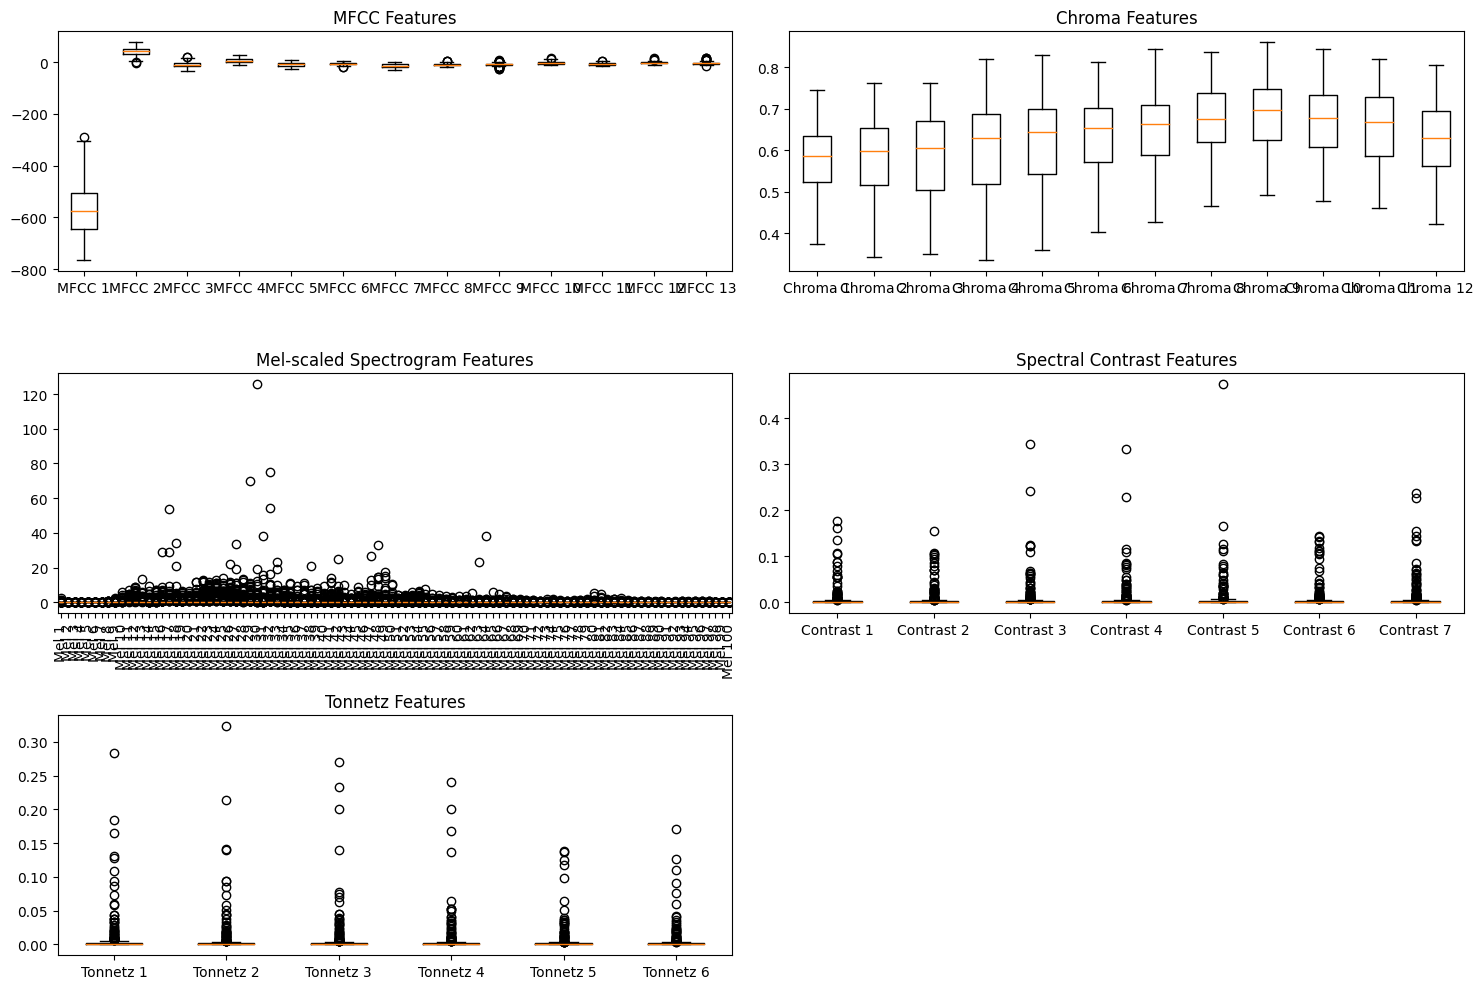

In [28]:
def visualize_features(X):
    mfcc_features = X[:, :13]
    chroma_features = X[:, 13:25]
    mel_features = X[:, 25:125]
    contrast_features = X[:, 125:132]
    tonnetz_features = X[:, 132:138]

    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.boxplot(mfcc_features)
    plt.title('MFCC Features')
    plt.xticks(range(1, 14), [f'MFCC {i}' for i in range(1, 14)])

    plt.subplot(3, 2, 2)
    plt.boxplot(chroma_features)
    plt.title('Chroma Features')
    plt.xticks(range(1, 13), [f'Chroma {i}' for i in range(1, 13)])

    plt.subplot(3, 2, 3)
    plt.boxplot(mel_features)
    plt.title('Mel-scaled Spectrogram Features')
    plt.xticks(range(1, 101), [f'Mel {i}' for i in range(1, 101)], rotation=90)

    plt.subplot(3, 2, 4)
    plt.boxplot(contrast_features)
    plt.title('Spectral Contrast Features')
    plt.xticks(range(1, 8), [f'Contrast {i}' for i in range(1, 8)])

    plt.subplot(3, 2, 5)
    plt.boxplot(tonnetz_features)
    plt.title('Tonnetz Features')
    plt.xticks(range(1, 7), [f'Tonnetz {i}' for i in range(1, 7)])

    plt.tight_layout()
    plt.show()

visualize_features(X)